# False Discoveries occur Early on the Lasso Path
### *Weijie Su, Malgorzata Bogdan, and Emmanuel Candes, 2015*

In this notebook, we shall try to show the limitations of the Lasso estimator in a regime of linear sparsity, based on the article of Weijie Su, Malgorzata Bogdan, and Emmanuel Candes. We will show that in this framework, there is a sharp asymptotic trade-off between false and true positive rates.

We first recall the hypotheses of the model:
- $X \in \mathbf{R}^{n*p}$, $\beta \in \mathbf{R}^{p}, z \in \mathbf{R}^{n}$, we consider the linear regression $y = X\beta + z$, where z is a noisy term
- $\hat{\beta}(\lambda) = argmin_{b \in \mathbf{R}^{p}} \frac{1}{2} \| y - Xb \|^2 + \lambda \|b\|_1$
- $\forall i=1...n, j=1...p,$ $x_{ij} \sim \mathcal{N}(0, \frac{1}{n})$ $iid$, so that $X_j \sim \mathcal{N}(0, 1)$
- $\forall i=1...n$, $z_i \sim \mathcal{N}(0, \sigma^2)$, and the case $\sigma = 0$ (no noise) is not exluded
- $\beta_1, ..., \beta_p$ are independent copies of a random variable $\Pi$ such that $\mathbb{E}(\Pi)<\infty$ and with $\mathbb{P}(\Pi \neq 0)=\epsilon$. $\epsilon$ hence represents the sparsity of $X$.
- $X, \beta, z$ are independent
- We suppose a linear sparsity: the number of non zero coefficients writes $\epsilon . p$
- We suppose $n, p \to \infty$ with $\frac{n}{p} \to \delta$ ($n \lt \lt p$)
- $k = \{j $ | $ \beta_j \neq 0\}$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

from numpy.random import multivariate_normal
from numpy.random import randn
from scipy.stats import norm
from sklearn.linear_model import lasso_path
from scipy.optimize import fminbound

We study the behaviour of the Lasso in a linear sparsity regime, which allows us to describe the performance of the Lasso in practical settings with moderately large dimensions and reasonable values of the degree of sparsity, including rather sparse signals. In the example described below, we take $n=1000$, $p=1000$ (and hence $\delta =1$), and $\epsilon = 0.2$.

## First findings

Text(0.5,1,'True coefficients of beta')

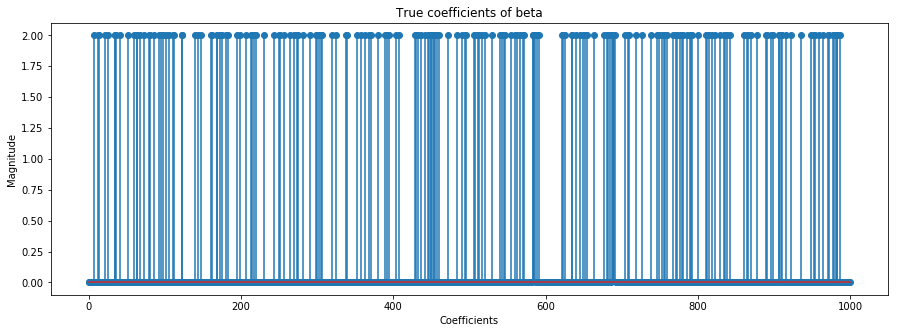

In [2]:
p = 1000 
n = 1000
epsi = 0.2
k = int(epsi * p) 
M = 2 # Value of non zero coefficients
beta = np.ones(p)*M
beta[k:] = 0.
random.shuffle(beta)

plt.figure(figsize=(15, 5))
plt.stem(beta)
plt.xlabel("Coefficients")
plt.ylabel("Magnitude")
plt.title("True coefficients of beta")

We observe $y = X\beta + z$.

For simplicity, in this first introductory example, we assume $\sigma = 0$, that is to say no noise. In this model, we only select the 200 fisrt variables, with a signal equal to 2 for each of them.

In [3]:
sigma = 0 # noise level

X = multivariate_normal(np.zeros(p), np.identity(p), size=n)
z = sigma * randn(n)
y = np.dot(X, beta) + z

We then compute the Lasso path: $\{\hat{\beta}(\lambda) : \lambda \geq0\}$

In [4]:
path = lasso_path(X, y, n_alphas=200)

In [5]:
lbd = path[0][50]

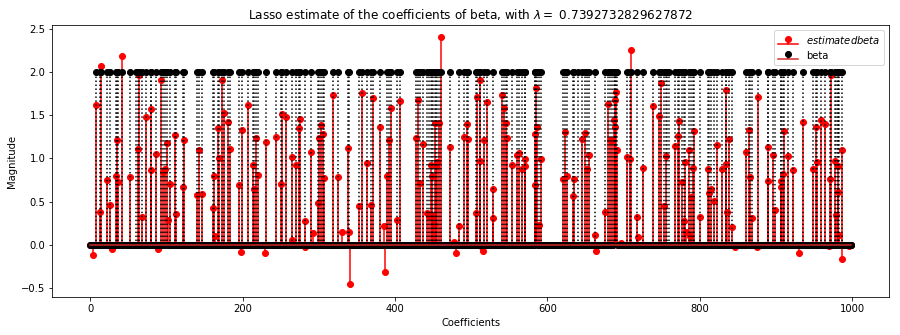

In [6]:
plt.figure(figsize=(15, 5))
plt.stem(path[1][:,50], linefmt='r-', markerfmt='ro', basefmt='r-', label='$estimated beta$')
plt.stem(beta, linefmt='k:', markerfmt='ko', label='beta')
plt.xlabel("Coefficients")
plt.ylabel("Magnitude")
plt.title("Lasso estimate of the coefficients of beta, with $\lambda=$ {}".format(lbd))
plt.legend()

We can observe on the graph above that:
- Most of the non zero coefficients of beta are shrinked (with an estimate value less than M=2). 
- Some of the true signals are not selected. 
- The Lasso selects some irrelevant variables.

In this notebook, we will focus on the support recovery issue. The remarks below suggest that in the conseidered example, we already have a significant proportion of type I and type II errors.

## Type I and type II erros

We define below FDP (False Discoveries Proportion) and TPP (True Positive Proportion). Our foal is to achieve a TPP as high as possible while controlling FDP.

$V$ (resp. $T$) denotes the number of Lasso false (reps. true) discoveries. Formally, $V(\lambda) = |\{j: \hat{\beta}_j(\lambda) \neq 0 $ and $ \beta_j = 0 \}|$ and $T(\lambda) = |\{j: \hat{\beta}_j(\lambda) \neq 0 $ and $ \beta_j \neq 0 \}|$. 
Then, $FDP(\lambda) = \frac{V(\lambda)}{|\{j: \hat{\beta}_j(\lambda) \neq 0\}| \vee 1}$ and $TPP(\lambda) = \frac{T(\lambda)}{k \vee 1}$.

$FDP$ corresponds to type I error, $1-TPP$ corresponds to type II error.

In [7]:
def fdp(beta_hat, beta):
    """Function that computes the False Discoveries Proportion for a given estimated beta"""
    V = 0
    k_hat = 0
    for i in range(0, len(beta)):
        if beta[i] == 0 and beta_hat[i] != 0:
            V += 1
        if beta_hat[i] != 0:
            k_hat += 1
    ratio = V / max(k_hat, 1)
    return ratio
    
def tpp(beta_hat, beta):
    """Function that computes the True Positive Proportion for a given estimated beta"""
    T = 0
    k = 0
    for i in range(0, len(beta)):
        if beta[i] != 0 and beta_hat[i] != 0:
            T += 1
        if beta[i] != 0:
            k += 1
    ratio = T / max(k, 1)
    return ratio

In [8]:
def errors_lasso_example(X, y, beta):
    """Function that computes FDP and TPP along the Lasso path"""
    n_lambdas = 500
    path = lasso_path(X, y, n_alphas=n_lambdas)[1]
    FDP = list()
    TPP = list()
    for i in range(0, n_lambdas):
        beta_hat = path[:, i]
        FDP.append(fdp(beta_hat, beta))
        TPP.append(tpp(beta_hat, beta))
    return FDP, TPP

In [9]:
FDP, TPP = errors_lasso_example(X, y, beta)

Text(0.5,1,'True positive and false positive rates along the Lasso path')

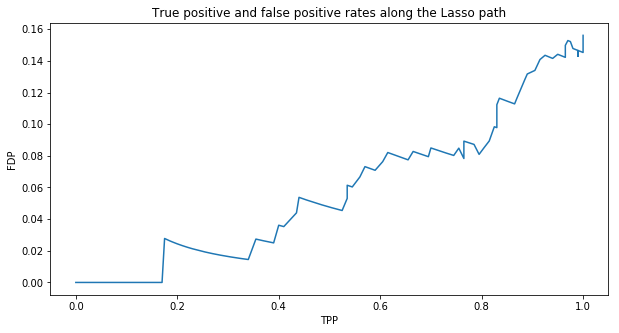

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(TPP, FDP)
plt.xlabel("TPP")
plt.ylabel("FDP")
plt.title("True positive and false positive rates along the Lasso path")

The graph above shows that in the example described, one cannot recover the complete true support of $\beta$ without making false discoveries. In particular, it shows that one needs to accept a $FDP$ rate equal to $0.2$ to recover the full support of $\beta$. Nowhere one the Lasso path can both types of error rates be simultaneously low.

## The boundary curve $q^*$

We compute the boundary curve $q^*$ using the matlab code provided by the authors at https://github.com/wjsu/fdrlasso. This curve represents the Lasso trade-off diagramm as it separates the unachievable couples of $(TPP, FDP)$ from the achievable ones.

In [11]:
tpp_clip = []
def fdrlasso(tpp, delta, epsi):
    
    if tpp > powermax(delta, epsi):
        tpp_clip.append(tpp)
        return tpp_clip[0]

    if tpp == 0:
        q = 0

    stepsize = 0.1
    tmax = max(10, np.sqrt(delta/epsi/tpp) + 1)
    tmin = tmax - stepsize

    while tmin > 0:
        if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
            break
        tmax = tmin
        tmin = tmax - stepsize

    if tmin <= 0:
        stepsize = stepsize/100
        tmax = max(10, np.sqrt(delta/epsi/tpp) + 1)
        tmin = tmax - stepsize
        while tmin > 0:
            if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
                break 
        tmax = tmin
        tmin = tmax - stepsize

    diff = tmax - tmin
    while diff > 1e-6:
        tmid = 0.5*tmax + 0.5*tmin
        if lsandwich(tmid, tpp, delta, epsi) > rsandwich(tmid, tpp):
            tmax = tmid
        else: 
            tmin = tmid
        diff = tmax - tmin

    t = (tmax + tmin)/2

    q = 2*(1-epsi)*norm.cdf(-t)/(2*(1-epsi)*norm.cdf(-t) + epsi*tpp)

    return q


def lsandwich(t, tpp, delta, epsi):
    Lnume = (1-epsi)*(2*(1+t**2)*norm.cdf(-t) - 2*t*norm.pdf(t)) + epsi*(1+t**2) - delta
    Ldeno = epsi*((1+t**2)*(1-2*norm.cdf(-t)) + 2*t*norm.pdf(t))
    L = Lnume/Ldeno
    return L

def rsandwich(t, tpp):
    R = (1 - tpp)/(1 - 2*norm.cdf(-t))
    return R

def powermax(delta, epsilon):
    if delta >= 1:
        power = 1
    epsilon_star = epsilonDT(delta)
    if epsilon <= epsilon_star:
        power = 1
    power = (epsilon - epsilon_star)*(delta - epsilon_star)/epsilon/(1 - epsilon_star) + epsilon_star/epsilon
    return power

def epsilonDT(delta):
    def minus_f(x):
        return -(1+2/delta*x*norm.pdf(x) - 2/delta*(1+x**2)*norm.cdf(-x))/(1+x**2-2*(1+x**2)*norm.cdf(-x)\
                                                                           +2*x*norm.pdf(x))*delta
    alpha_phase = fminbound(minus_f, 0, 8)
    epsi = -minus_f(alpha_phase)
    return epsi

In [12]:
tpp_clip = []
interval = (np.arange(99) + 1) / 100
boundary_curve = np.array([fdrlasso(tpp=elt, delta=0.5, epsi=0.15) for elt in interval])
if tpp_clip != []:
    for i in range(len(interval)):
        if boundary_curve[i] == tpp_clip[0]:
            boundary_curve[i] = 1

(0, 1)

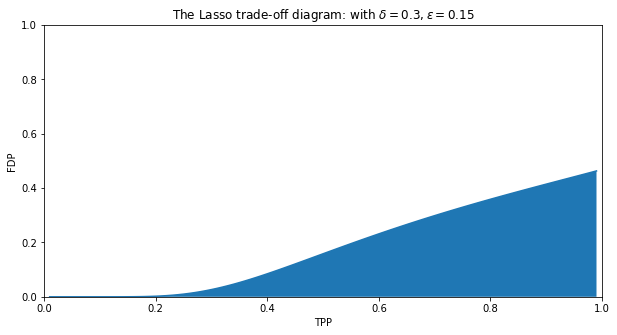

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(interval, boundary_curve)
plt.xlabel("TPP")
plt.ylabel("FDP")
plt.title("The Lasso trade-off diagram: with $\delta=0.3, \epsilon=0.15$")
if tpp_clip != []:
    plt.axvline(x=tpp_clip[0])
plt.fill_between(interval, boundary_curve)
plt.xlim(0, 1)
plt.ylim(0, 1)

The blue area represents the unachievable rates of FDP and TPP.

## Experiments

In [14]:
def errors_lasso(n, p, epsi, sigma=0):
    """Function that computes FDP and TPP along the Lasso path"""
    
    delta = n/p
    
    # Computation of the true beta
    k = int(epsi * p) 
    M = 2 # Value of non zero coefficients
    beta = np.ones(p)*M
    beta[k:] = 0.
    
    # Parameters of the model
    X = multivariate_normal(np.zeros(p), np.identity(p), size=n)
    z = sigma * randn(n)
    y = np.dot(X, beta) + z
    
    # Computation of FDP and TPP
    n_lambdas = 200
    path = lasso_path(X, y, n_alphas=n_lambdas)[1]
    FDP = list()
    TPP = list()
    for i in range(0, n_lambdas):
        beta_hat = path[:, i]
        FDP.append(fdp(beta_hat, beta))
        TPP.append(tpp(beta_hat, beta))  
        
    # Computation of the boundary curve
    tpp_clip = []
    interval = (np.arange(99) + 1) / 100
    boundary_curve = np.array([fdrlasso(tpp=elt, delta=delta, epsi=epsi) for elt in interval])
    if tpp_clip != []:
        for i in range(len(interval)):
            if boundary_curve[i] == tpp_clip[0]:
                boundary_curve[i] = 1
        

    return FDP, TPP, boundary_curve

Text(0.5,1,'True positive and false positive rates along the Lasso path')

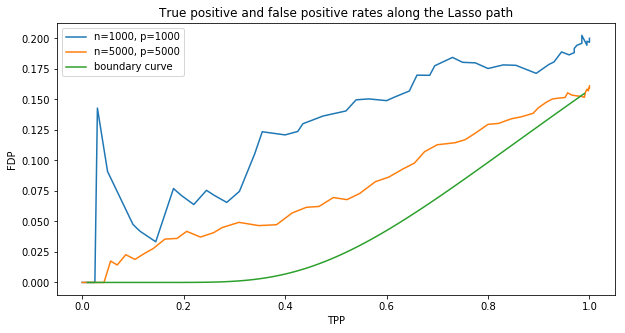

In [16]:
values = [1000, 5000]
plt.figure(figsize=(10, 5))
for value in values:
    FDP, TPP, boundary_curve = errors_lasso(n=value, p=value, epsi=0.2, sigma=0)
    plt.plot(TPP, FDP)
plt.plot(interval, boundary_curve)
plt.xlabel("TPP")
plt.ylabel("FDP")
plt.legend(["n={}, p={}".format(value, value) for value in values] + ['boundary curve'])
plt.title("True positive and false positive rates along the Lasso path")

# The Bolasso
### *Francis Bach, 2008*

We now turn to the implementation of the Bolasso. Keeping the hypotheses of our article, we empirically study the performance of the Bolasso. We observe that, for sufficiently large values of $m$ (the number of bootstrap samples), this algorithm succeeds to achieve a high TPP while keeping the FDP at a very low level.

In [17]:
from sklearn.utils import resample
def bolasso_supports(X, y, beta, n_bootstrap):
    """Function that computes the intersection of the supports along the Bolasso path"""
    
    all_supports = []
    for k in range(n_bootstrap):
        Xk, yk = resample(X, y)
        beta_list, all_betas, _ = lasso_path(Xk, yk, n_alphas=500)
        all_supports.append([np.where(all_betas[:,i] != 0) for i in range(len(beta_list))])
    
    inter = []
    for i in range(len(beta_list)):
        inter_beta = np.array([k for k in range(len(beta))])
        for j in range(len(all_supports)):
            inter_beta = np.intersect1d(inter_beta, all_supports[j][i][0])
        inter.append(inter_beta)
    
    return inter

In [18]:
def error_bolasso(beta, path_support):
    """Function that computes TPP and FDP along the Bolasso path"""
    TPP = []
    FDP = []
    for support in path_support:
        beta_hat = np.zeros(len(beta))
        beta_hat[support] = 2
        TPP.append(tpp(beta_hat, beta))
        FDP.append(fdp(beta_hat, beta))
    return TPP, FDP

In [19]:
# Computation of the boundary curve
tpp_clip = []
delta = n / p
epsi = epsi
interval = (np.arange(99) + 1) / 100
boundary_curve = np.array([fdrlasso(tpp=elt, delta=delta, epsi=epsi) for elt in interval])
if tpp_clip != []:
    for i in range(len(interval)):
        if boundary_curve[i] == tpp_clip[0]:
            boundary_curve[i] = 1

In [20]:
# Comparing the performance of the bolasso for different values of number of resamplings
tpp_fdp = []
K = 6
for m in range(1, K):
    supports = bolasso_supports(X, y, beta, m)
    errors = error_bolasso(beta, supports)
    tpp_fdp.append(errors)

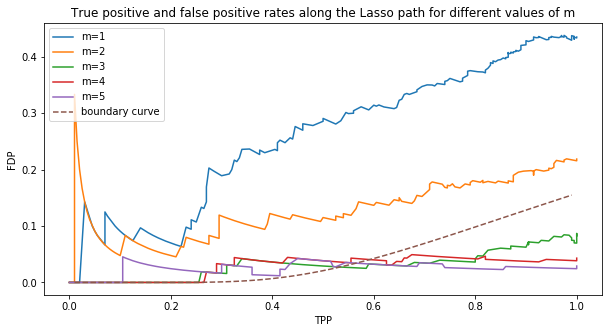

In [21]:
plt.figure(figsize=(10, 5))
legends = ['m={}'.format(m) for m in range(1, K)] + ['boundary curve']
for error in tpp_fdp:
    TPP, FDP = error
    plt.plot(TPP, FDP)
plt.plot(interval, boundary_curve, linestyle='--')
plt.xlabel("TPP")
plt.ylabel("FDP")
plt.title("True positive and false positive rates along the Lasso path for different values of m")
plt.legend(legends)